# Napa County Model

Build the model for Napa County California. The goal of the model will be to predict the total burn area of wildfires in Napa County for a given month

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression, Lasso

In [3]:
def evaluate(train_pred, train_actual, test_pred, test_actual):
    train_rmse = np.sqrt(mean_squared_error(train_pred, train_actual))
    train_mape = mean_absolute_percentage_error(train_pred, train_actual)
    train_mae = median_absolute_error(train_pred, train_actual)

    test_rmse = np.sqrt(mean_squared_error(test_pred, test_actual))
    test_mape = mean_absolute_percentage_error(test_pred, test_actual)
    test_mae = median_absolute_error(test_pred, test_actual)

    metric_df = pd.DataFrame({'Train': [train_rmse, train_mape, train_mae], 
                            'Test': [test_rmse, test_mape, test_mae]},
                           index=['Root Mean Squared Error', 'Mean Absolute Percent Error', 'Median Absolute Error'])
    
    return metric_df

Read in the data and prep Napa County

In [2]:
fire_data = pd.read_csv("./Data/clean_fire_data.csv", parse_dates=["MONTH"])
fire_data['FIPS_CODE'] = fire_data['FIPS_CODE'].astype(str).str.zfill(5)
fire_data['STATE_CODE'] = fire_data['FIPS_CODE'].str.slice(0, 2)

weather_data = pd.read_csv("./Data/cleaned_weather_data.csv", parse_dates=['MONTH'])
weather_data['STATE_CODE'] = weather_data['STATE_CODE'].astype(str).str.zfill(2)

min_month = min(fire_data['MONTH'])
max_month = max(fire_data['MONTH'])

indx = pd.date_range(start=min_month, end=max_month, freq='MS')

complete_data = pd.DataFrame(np.dstack(np.meshgrid(np.unique(fire_data['FIPS_CODE']), indx)).reshape(-1, 2), 
                             columns=['FIPS_CODE', 'MONTH'])

complete_data['MONTH'] = pd.to_datetime(complete_data['MONTH'])

fips_data = fire_data.groupby(by='FIPS_CODE').agg({'COUNTY_AREA': min, 'STATE_CODE': min}).reset_index()

full_data = pd.merge(complete_data, fire_data[['FIPS_CODE', 'MONTH', 'TOTAL_BURN_AREA']], 
                     how='left', on=['FIPS_CODE', 'MONTH']).fillna(0)

full_data = pd.merge(full_data, fips_data, how='inner', on=['FIPS_CODE'])

final_data = pd.merge(full_data, weather_data, how='inner', on=['MONTH', 'STATE_CODE'])

final_data['MONTH_VALUE'] = final_data['MONTH'].dt.month

final_data.sort_values(by=['FIPS_CODE', 'MONTH'], inplace=True)

cols = ["TOTAL_BURN_AREA", "PRCP", "TMIN", "TMAX"]
lags = [1, 2, 3, 4, 5, 6, 11, 12, 13, 23, 24, 25]
for c in cols:
    for l in lags:
        final_data[f"{c}_lag{l}"] = final_data.groupby('FIPS_CODE')[c].shift(l)

final_data.dropna(inplace=True)

### Linear Model

In [37]:
y_column = ['TOTAL_BURN_AREA']
x_columns = ['COUNTY_AREA', 'FIPS_CODE',
                 'PRCP', 'TMAX', 'TOTAL_BURN_AREA_lag1',
                 'TOTAL_BURN_AREA_lag12']

model_data = final_data[y_column + x_columns]

ohe = OneHotEncoder(drop='first', sparse=False).fit(model_data[['FIPS_CODE']])
model_data[ohe.get_feature_names_out()] = ohe.transform(model_data[['FIPS_CODE']])
model_data[x_columns] = StandardScaler().fit_transform(model_data[x_columns])

train_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[:-24])
test_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[-24:])

X_Train, y_train = train_data.drop(['TOTAL_BURN_AREA'], axis=1), train_data['TOTAL_BURN_AREA']
X_Test, y_test =  test_data.drop(['TOTAL_BURN_AREA'], axis=1), test_data['TOTAL_BURN_AREA']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [38]:
model = LinearRegression().fit(X_Train, y_train)

train_preds = model.predict(X_Train)
test_preds = model.predict(X_Test)

evaluate(train_preds, y_train, test_preds, y_test)

,Train,Test
Root Mean Squared Error,8746.222305,11963.018420
Mean Absolute Percent Error,1.339828,1.941325
Median Absolute Error,742.957057,779.117126


### Lasso Regression

Use same train and test data as Linear Regression

In [40]:
model = Lasso(alpha=0.1).fit(X_Train, y_train)

train_preds = model.predict(X_Train)
test_preds = model.predict(X_Test)

evaluate(train_preds, y_train, test_preds, y_test)

,Train,Test
Root Mean Squared Error,8746.418783,11963.993257
Mean Absolute Percent Error,1.458676,1.912727
Median Absolute Error,737.070416,774.356615


Adjust the Lasso regularization parameter from 0.1 to 0.5

In [41]:
model = Lasso(alpha=0.5).fit(X_Train, y_train)

train_preds = model.predict(X_Train)
test_preds = model.predict(X_Test)

evaluate(train_preds, y_train, test_preds, y_test)

,Train,Test
Root Mean Squared Error,8748.037998,11967.852217
Mean Absolute Percent Error,1.269488,2.279091
Median Absolute Error,721.676720,765.988434


In [42]:
final_data.columns

Index(['FIPS_CODE', 'MONTH', 'TOTAL_BURN_AREA', 'COUNTY_AREA', 'STATE_CODE',
       'STATE', 'PRCP', 'TMAX', 'TMIN', 'MONTH_VALUE', 'TOTAL_BURN_AREA_lag1',
       'TOTAL_BURN_AREA_lag2', 'TOTAL_BURN_AREA_lag3', 'TOTAL_BURN_AREA_lag4',
       'TOTAL_BURN_AREA_lag5', 'TOTAL_BURN_AREA_lag6', 'TOTAL_BURN_AREA_lag11',
       'TOTAL_BURN_AREA_lag12', 'TOTAL_BURN_AREA_lag13',
       'TOTAL_BURN_AREA_lag23', 'TOTAL_BURN_AREA_lag24',
       'TOTAL_BURN_AREA_lag25', 'PRCP_lag1', 'PRCP_lag2', 'PRCP_lag3',
       'PRCP_lag4', 'PRCP_lag5', 'PRCP_lag6', 'PRCP_lag11', 'PRCP_lag12',
       'PRCP_lag13', 'PRCP_lag23', 'PRCP_lag24', 'PRCP_lag25', 'TMIN_lag1',
       'TMIN_lag2', 'TMIN_lag3', 'TMIN_lag4', 'TMIN_lag5', 'TMIN_lag6',
       'TMIN_lag11', 'TMIN_lag12', 'TMIN_lag13', 'TMIN_lag23', 'TMIN_lag24',
       'TMIN_lag25', 'TMAX_lag1', 'TMAX_lag2', 'TMAX_lag3', 'TMAX_lag4',
       'TMAX_lag5', 'TMAX_lag6', 'TMAX_lag11', 'TMAX_lag12', 'TMAX_lag13',
       'TMAX_lag23', 'TMAX_lag24', 'TMAX_lag25'],
   

### CatBoost Model - Regression Component Only

We want to see the raw performance of our input variables

In [44]:
y_column = ['TOTAL_BURN_AREA']
x_columns = ['FIPS_CODE', 'COUNTY_AREA', 'STATE', 'PRCP', 'TMAX', 'TMIN', 
             'PRCP_lag1', 'PRCP_lag2', 'PRCP_lag3',
             'PRCP_lag4', 'PRCP_lag5', 'PRCP_lag6', 'PRCP_lag11', 'PRCP_lag12',
             'PRCP_lag13', 'PRCP_lag23', 'PRCP_lag24', 'PRCP_lag25', 'TMIN_lag1',
             'TMIN_lag2', 'TMIN_lag3', 'TMIN_lag4', 'TMIN_lag5', 'TMIN_lag6',
             'TMIN_lag11', 'TMIN_lag12', 'TMIN_lag13', 'TMIN_lag23', 'TMIN_lag24',
             'TMIN_lag25', 'TMAX_lag1', 'TMAX_lag2', 'TMAX_lag3', 'TMAX_lag4',
             'TMAX_lag5', 'TMAX_lag6', 'TMAX_lag11', 'TMAX_lag12', 'TMAX_lag13',
             'TMAX_lag23', 'TMAX_lag24', 'TMAX_lag25']

model_data = final_data[y_column + x_columns]

train_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[:-24])
test_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[-24:])

X_Train, y_train = train_data.drop(['TOTAL_BURN_AREA'], axis=1), train_data['TOTAL_BURN_AREA']
X_Test, y_test =  test_data.drop(['TOTAL_BURN_AREA'], axis=1), test_data['TOTAL_BURN_AREA']

In [46]:
# Leave all parameters - except has_time as defaults

train_pool = Pool(X_Train, label=y_train, cat_features=['FIPS_CODE', 'STATE'])

model = CatBoostRegressor(iterations=1000, verbose=0, has_time=True, random_seed=42, 
                          min_data_in_leaf=1, max_depth=6).fit(train_pool)

train_preds = model.predict(X_Train)
test_preds = model.predict(X_Test)

evaluate(train_preds, y_train, test_preds, y_test)

,Train,Test
Root Mean Squared Error,6249.783062,12266.380698
Mean Absolute Percent Error,1.891524,3.132296
Median Absolute Error,136.683665,156.299973


In [47]:
# Increase the number of iterations
train_pool = Pool(X_Train, label=y_train, cat_features=['FIPS_CODE', 'STATE'])

model = CatBoostRegressor(iterations=1500, verbose=0, has_time=True, random_seed=42, 
                          min_data_in_leaf=1, max_depth=6).fit(train_pool)

train_preds = model.predict(X_Train)
test_preds = model.predict(X_Test)

evaluate(train_preds, y_train, test_preds, y_test)

,Train,Test
Root Mean Squared Error,6448.095689,12328.715918
Mean Absolute Percent Error,3.603841,9.255540
Median Absolute Error,139.441775,162.452083


Reduce the number of input variables using feature importance. Take only feature which contribute 1% importance

In [60]:
pd.DataFrame(zip(X_Train.columns, model.feature_importances_), 
             columns=['Column', 'Importance']).sort_values('Importance', ascending=False).tail(15)

,Column,Importance
33,TMAX_lag4,1.065032
10,PRCP_lag5,0.932098
26,TMIN_lag13,0.900002
38,TMAX_lag13,0.858970
22,TMIN_lag5,0.858470
29,TMIN_lag25,0.769355
31,TMAX_lag2,0.734839
32,TMAX_lag3,0.717733
19,TMIN_lag2,0.712731
16,PRCP_lag24,0.639589


In [61]:
y_column = ['TOTAL_BURN_AREA']
x_columns = ['FIPS_CODE', 'COUNTY_AREA', 'STATE', 'PRCP', 'TMAX', 'TMIN', 
             'PRCP_lag1', 'PRCP_lag2',
             'PRCP_lag4', 'PRCP_lag11', 'PRCP_lag12',
             'PRCP_lag13', 'PRCP_lag23','PRCP_lag25',
             'TMIN_lag3', 'TMIN_lag6',
             'TMIN_lag12', 'TMIN_lag23', 'TMIN_lag24',
             'TMAX_lag1',
             'TMAX_lag5', 'TMAX_lag6', 'TMAX_lag11', 'TMAX_lag12',
             'TMAX_lag23', 'TMAX_lag24', 'TMAX_lag25']

model_data = final_data[y_column + x_columns]

train_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[:-24])
test_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[-24:])

X_Train, y_train = train_data.drop(['TOTAL_BURN_AREA'], axis=1), train_data['TOTAL_BURN_AREA']
X_Test, y_test =  test_data.drop(['TOTAL_BURN_AREA'], axis=1), test_data['TOTAL_BURN_AREA']

In [62]:
train_pool = Pool(X_Train, label=y_train, cat_features=['FIPS_CODE', 'STATE'])

model = CatBoostRegressor(iterations=1500, verbose=0, has_time=True, random_seed=42, 
                          min_data_in_leaf=1, max_depth=6).fit(train_pool)

train_preds = model.predict(X_Train)
test_preds = model.predict(X_Test)

evaluate(train_preds, y_train, test_preds, y_test)

,Train,Test
Root Mean Squared Error,6495.144073,12200.380468
Mean Absolute Percent Error,4.293248,3.444550
Median Absolute Error,136.538496,172.832314


In [65]:
final_data.columns

Index(['FIPS_CODE', 'MONTH', 'TOTAL_BURN_AREA', 'COUNTY_AREA', 'STATE_CODE',
       'STATE', 'PRCP', 'TMAX', 'TMIN', 'MONTH_VALUE', 'TOTAL_BURN_AREA_lag1',
       'TOTAL_BURN_AREA_lag2', 'TOTAL_BURN_AREA_lag3', 'TOTAL_BURN_AREA_lag4',
       'TOTAL_BURN_AREA_lag5', 'TOTAL_BURN_AREA_lag6', 'TOTAL_BURN_AREA_lag11',
       'TOTAL_BURN_AREA_lag12', 'TOTAL_BURN_AREA_lag13',
       'TOTAL_BURN_AREA_lag23', 'TOTAL_BURN_AREA_lag24',
       'TOTAL_BURN_AREA_lag25', 'PRCP_lag1', 'PRCP_lag2', 'PRCP_lag3',
       'PRCP_lag4', 'PRCP_lag5', 'PRCP_lag6', 'PRCP_lag11', 'PRCP_lag12',
       'PRCP_lag13', 'PRCP_lag23', 'PRCP_lag24', 'PRCP_lag25', 'TMIN_lag1',
       'TMIN_lag2', 'TMIN_lag3', 'TMIN_lag4', 'TMIN_lag5', 'TMIN_lag6',
       'TMIN_lag11', 'TMIN_lag12', 'TMIN_lag13', 'TMIN_lag23', 'TMIN_lag24',
       'TMIN_lag25', 'TMAX_lag1', 'TMAX_lag2', 'TMAX_lag3', 'TMAX_lag4',
       'TMAX_lag5', 'TMAX_lag6', 'TMAX_lag11', 'TMAX_lag12', 'TMAX_lag13',
       'TMAX_lag23', 'TMAX_lag24', 'TMAX_lag25'],
   

### CatBoost Model - Include AR Terms

Using the regression terms from the past model we now add in the AR terms for total burn area

In [66]:
y_column = ['TOTAL_BURN_AREA']
x_columns = ['TOTAL_BURN_AREA_lag1',
             'TOTAL_BURN_AREA_lag2', 'TOTAL_BURN_AREA_lag3', 'TOTAL_BURN_AREA_lag4',
             'TOTAL_BURN_AREA_lag5', 'TOTAL_BURN_AREA_lag6', 'TOTAL_BURN_AREA_lag11',
             'TOTAL_BURN_AREA_lag12', 'TOTAL_BURN_AREA_lag13',
             'TOTAL_BURN_AREA_lag23', 'TOTAL_BURN_AREA_lag24',
             'TOTAL_BURN_AREA_lag25',
             'FIPS_CODE', 'COUNTY_AREA', 'STATE', 'PRCP', 'TMAX', 'TMIN', 
             'PRCP_lag1', 'PRCP_lag2',
             'PRCP_lag4', 'PRCP_lag11', 'PRCP_lag12',
             'PRCP_lag13', 'PRCP_lag23','PRCP_lag25',
             'TMIN_lag3', 'TMIN_lag6',
             'TMIN_lag12', 'TMIN_lag23', 'TMIN_lag24',
             'TMAX_lag1',
             'TMAX_lag5', 'TMAX_lag6', 'TMAX_lag11', 'TMAX_lag12',
             'TMAX_lag23', 'TMAX_lag24', 'TMAX_lag25']

model_data = final_data[y_column + x_columns]

train_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[:-24])
test_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[-24:])

X_Train, y_train = train_data.drop(['TOTAL_BURN_AREA'], axis=1), train_data['TOTAL_BURN_AREA']
X_Test, y_test =  test_data.drop(['TOTAL_BURN_AREA'], axis=1), test_data['TOTAL_BURN_AREA']

In [68]:
train_pool = Pool(X_Train, label=y_train, cat_features=['FIPS_CODE', 'STATE'])

model = CatBoostRegressor(iterations=1500, verbose=0, has_time=True, random_seed=42, 
                          min_data_in_leaf=10, max_depth=5).fit(train_pool)

train_preds = model.predict(X_Train)
test_preds = model.predict(X_Test)

evaluate(train_preds, y_train, test_preds, y_test)

,Train,Test
Root Mean Squared Error,4866.256812,11822.649528
Mean Absolute Percent Error,2.595243,3.024965
Median Absolute Error,118.085537,143.707604


Reduce the number of features using the feature importance, remove any inputs which have importance less than 1

In [69]:
pd.DataFrame(zip(X_Train.columns, model.feature_importances_), 
             columns=['Column', 'Importance']).sort_values('Importance', ascending=False).tail(15)

,Column,Importance
22,PRCP_lag12,1.363422
37,TMAX_lag24,1.321837
26,TMIN_lag3,1.253601
4,TOTAL_BURN_AREA_lag5,1.124486
21,PRCP_lag11,1.101426
27,TMIN_lag6,1.048223
3,TOTAL_BURN_AREA_lag4,0.952245
17,TMIN,0.950940
25,PRCP_lag25,0.860334
14,STATE,0.790754


In [70]:
y_column = ['TOTAL_BURN_AREA']
x_columns = ['TOTAL_BURN_AREA_lag1',
             'TOTAL_BURN_AREA_lag2', 'TOTAL_BURN_AREA_lag3',
             'TOTAL_BURN_AREA_lag5', 'TOTAL_BURN_AREA_lag11',
             'TOTAL_BURN_AREA_lag12', 'TOTAL_BURN_AREA_lag13',
             'TOTAL_BURN_AREA_lag23', 'TOTAL_BURN_AREA_lag24',
             'TOTAL_BURN_AREA_lag25',
             'FIPS_CODE', 'COUNTY_AREA', 'PRCP', 'TMAX',
             'PRCP_lag1',
             'PRCP_lag4', 'PRCP_lag11', 'PRCP_lag12',
             'PRCP_lag23',
             'TMIN_lag3', 'TMIN_lag6',
             'TMIN_lag12', 'TMIN_lag23', 'TMIN_lag24',
             'TMAX_lag6', 'TMAX_lag11', 'TMAX_lag12',
             'TMAX_lag23', 'TMAX_lag24', 'TMAX_lag25']

model_data = final_data[y_column + x_columns]

train_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[:-24])
test_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[-24:])

X_Train, y_train = train_data.drop(['TOTAL_BURN_AREA'], axis=1), train_data['TOTAL_BURN_AREA']
X_Test, y_test =  test_data.drop(['TOTAL_BURN_AREA'], axis=1), test_data['TOTAL_BURN_AREA']

In [72]:
train_pool = Pool(X_Train, label=y_train, cat_features=['FIPS_CODE'])

model = CatBoostRegressor(iterations=1500, verbose=0, has_time=True, random_seed=42, 
                          min_data_in_leaf=10, max_depth=5).fit(train_pool)

train_preds = model.predict(X_Train)
test_preds = model.predict(X_Test)

evaluate(train_preds, y_train, test_preds, y_test)

,Train,Test
Root Mean Squared Error,4803.126323,11948.096227
Mean Absolute Percent Error,2.502934,2.177156
Median Absolute Error,115.109850,131.239743


Check feature importances again to makes sure all features have importance > 1

In [73]:
pd.DataFrame(zip(X_Train.columns, model.feature_importances_), 
             columns=['Column', 'Importance']).sort_values('Importance', ascending=False).tail(15)

,Column,Importance
29,TMAX_lag25,2.359557
12,PRCP,2.329602
26,TMAX_lag12,2.256580
23,TMIN_lag24,2.147293
18,PRCP_lag23,2.123479
17,PRCP_lag12,2.067364
14,PRCP_lag1,2.041318
2,TOTAL_BURN_AREA_lag3,1.845799
10,FIPS_CODE,1.680536
20,TMIN_lag6,1.579870


### Compute Shaply Explanantions for the Final Model

In [74]:
import shap
shap.initjs()

In [75]:
samps = X_Train.sample(50000)

explainer = shap.TreeExplainer(model)
shap_vals = explainer(samps)

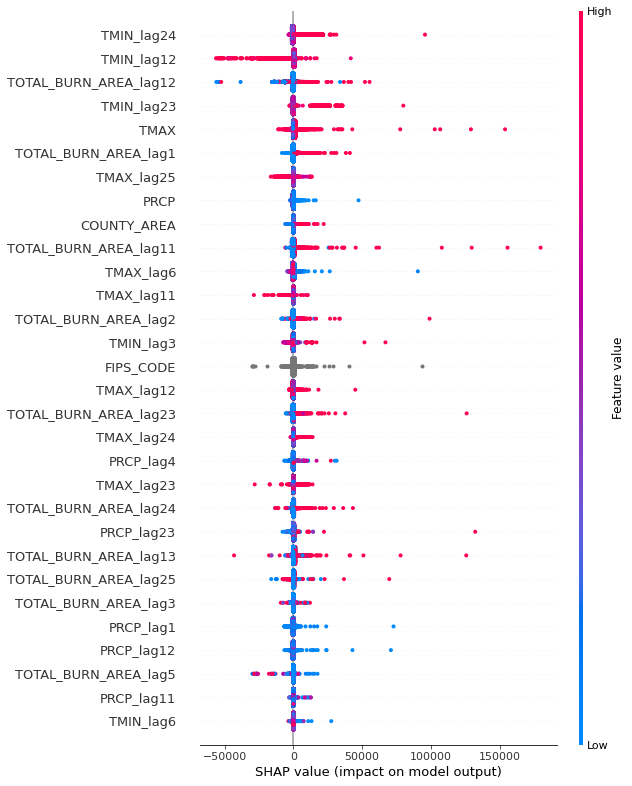

In [76]:
fig = shap.summary_plot(shap_values=shap_vals, features=samps, max_display=40)

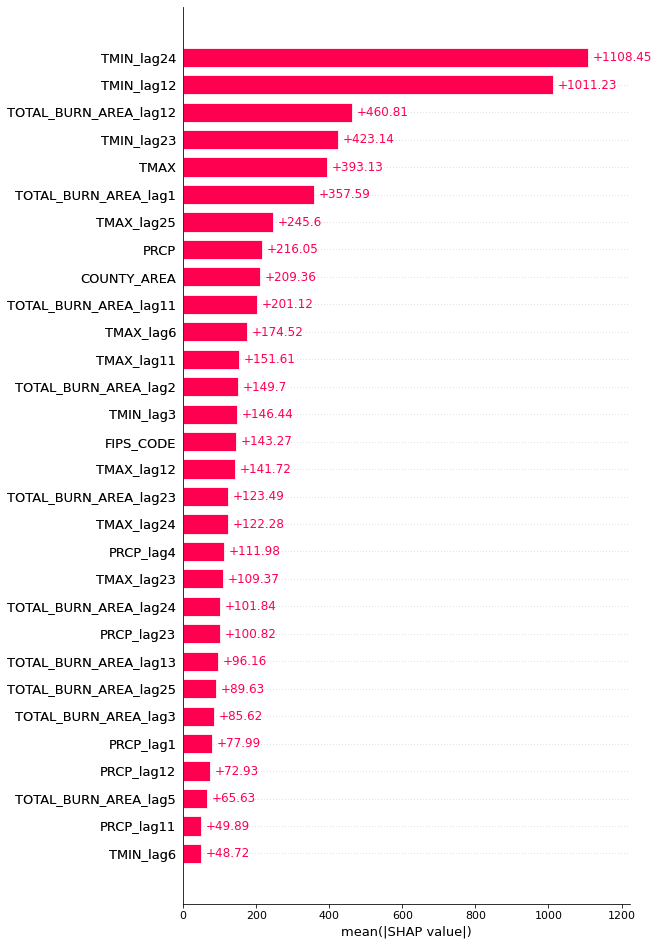

In [77]:
shap.plots.bar(shap_vals, max_display=31)

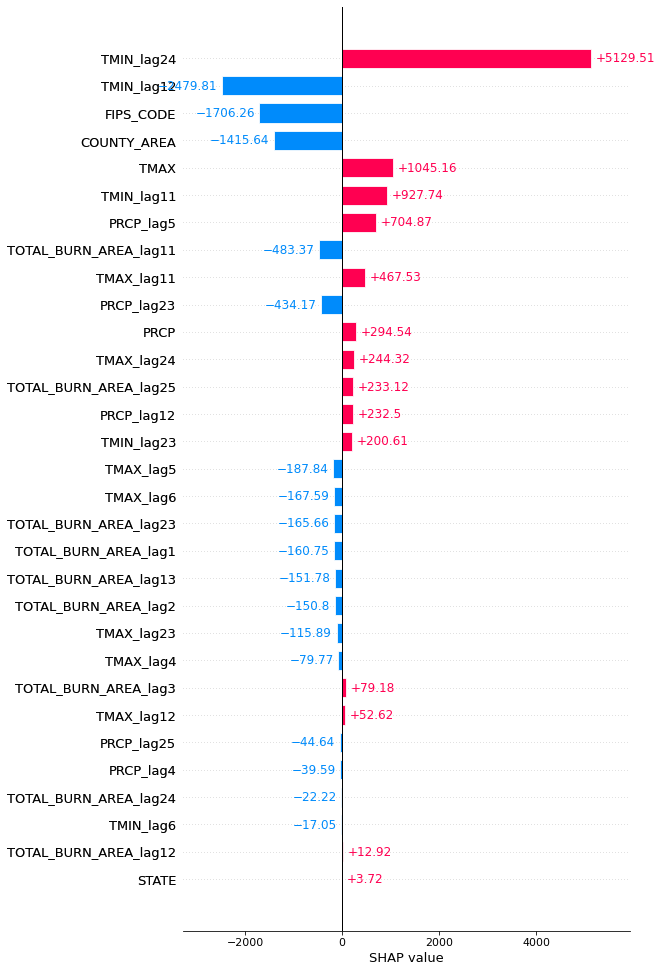

In [57]:
sample = final_data.iloc[np.where((final_data['FIPS_CODE'] == '06055') & 
                                  (final_data['MONTH'] == '2015-07-01'))][model_columns].drop(['TOTAL_BURN_AREA'], axis=1)
sample

exp = explainer(sample)

shap.plots.bar(exp[0], max_display=31)

In [78]:
fcst_train = X_Train.copy().reset_index(drop=True)
fcst_test = X_Test.copy().reset_index(drop=True)

fcst_train['Preds'] = np.clip(train_preds, a_min=0, a_max=None)
fcst_test['Preds'] = np.clip(test_preds, a_min=0, a_max=None)

napa_train_preds = fcst_train[fcst_train['FIPS_CODE'] == '06055']['Preds']
elko_train_preds = fcst_train[fcst_train['FIPS_CODE'] == '32007']['Preds']
napa_test_preds = fcst_test[fcst_test['FIPS_CODE'] == '06055']['Preds']
elko_test_preds = fcst_test[fcst_test['FIPS_CODE'] == '32007']['Preds']

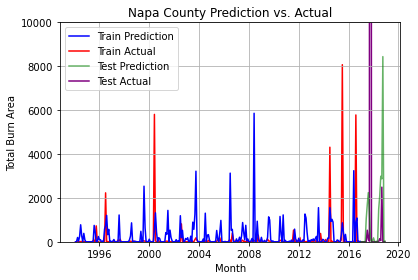

In [80]:
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '06055']['MONTH'][:-24], napa_train_preds.values, color='blue', zorder=2, 
        label='Train Prediction')
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '06055']['MONTH'][:-24], 
        final_data.loc[final_data['FIPS_CODE'] == '06055']['TOTAL_BURN_AREA'][:-24], color='red', zorder=1, 
        label='Train Actual')

plt.plot(final_data.loc[final_data['FIPS_CODE'] == '06055']['MONTH'][-24:], napa_test_preds.values, color='green', zorder=2,
        label='Test Prediction', alpha=0.6)
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '06055']['MONTH'][-24:], 
        final_data.loc[final_data['FIPS_CODE'] == '06055']['TOTAL_BURN_AREA'][-24:], color='purple', zorder=1,
        label='Test Actual')
plt.grid()
plt.title("Napa County Prediction vs. Actual")
plt.legend()
plt.ylabel("Total Burn Area")
plt.xlabel('Month')
plt.tight_layout()
plt.ylim(0, 10000)
plt.savefig("./img/NapaPredPlot.png")
plt.show()

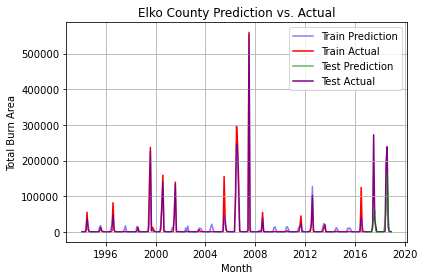

In [81]:
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '32007']['MONTH'][:-24], elko_train_preds.values, color='blue', zorder=2, 
        label='Train Prediction', alpha=0.5)
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '32007']['MONTH'][:-24], 
        final_data.loc[final_data['FIPS_CODE'] == '32007']['TOTAL_BURN_AREA'][:-24], color='red', zorder=1, 
        label='Train Actual', alpha=1)

plt.plot(final_data.loc[final_data['FIPS_CODE'] == '32007']['MONTH'][-24:], elko_test_preds.values, color='green', zorder=2,
        label='Test Prediction', alpha=0.6)
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '32007']['MONTH'][-24:], 
        final_data.loc[final_data['FIPS_CODE'] == '32007']['TOTAL_BURN_AREA'][-24:], color='purple', zorder=1,
        label='Test Actual')
plt.grid()
plt.title("Elko County Prediction vs. Actual")
plt.legend()
plt.ylabel("Total Burn Area")
plt.xlabel('Month')
plt.tight_layout()
plt.savefig("./img/ElkoPredPlot.png")
# plt.ylim(0, 150000)
plt.show()